In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from dataclasses import dataclass

In [4]:
def sfh_linexp(tau_sfh=5):
    return lambda t: t * np.exp(-t/tau_sfh)

In [5]:
surp.YieldParams()

YieldParams(c_cc_y0=None, c_cc_zeta=None, c_cc_model='A', c_cc_y1=0, c_cc_z1=0, c_agb_model='cristallo11', c_agb_alpha=1, c_agb_kwargs={}, n_agb_model='A', n_agb_eta=0.000502, n_agb_y0=0, n_cc_y0=0.0005, n_cc_zeta=0, fe_ia=0.00077, fe_cc=0.000473)

In [6]:
import sys
sys.path.append("../..")

In [7]:
from models import calc_yields

In [10]:
def set_yields(tau_agb=0.3, t_d_agb=0.1, f_agb=0.2, agb_model="A"):
    calc_yields.make_yield_params(agb_model=agb_model, )
        

    
def sz_model(dt=0.01, t_end=13.2, tau_sfh=5, eta=0.5, tau_star=2, mode="gas", RIa="exp", **kwargs):
    
    params = calc_yields.make_yield_params(**kwargs)
    surp.set_yields(params)
    sfh = sfh_linexp(tau_sfh)
    sz = vice.singlezone(elements=["o", "mg", "c", "fe", "n"], func=sfh, mode=mode, dt=dt, 
                         eta=eta,  tau_star=tau_star, Mg0=1)
    
    sz.RIa = RIa
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [11]:
sz = sz_model()

In [32]:
def calc_model(**params):
    sz = sz_model(**params)
    zo_a = np.array(sz.history["z(o)"])[2:]
    zfe_a = np.array(sz.history["z(fe)"])[2:]
    zc_a = np.array(sz.history["z(c)"])[2:]

    o_h_a = gcem.abund_to_brak(zo_a, "o")
    c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
    o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")
    
    return o_fe_a, c_o_a, np.ones(len(o_h_a))

In [13]:
def prob(x, y, xerr, yerr, xm, ym):
    return np.exp(-1/2 * ((y - ym)**2/yerr**2 + (x-xm)**2/xerr**2))

In [14]:
def log_prob(obs, model):
    x, y, xerr, yerr = obs
    xm, ym, w = model
    xm = xm.reshape((-1, 1))
    ym = ym.reshape((-1, 1))
    w = w.reshape((-1, 1)) 
    Σs = np.sum(w * prob(x, y, xerr, yerr, xm, ym), axis=0) # sum over model
    return np.sum(np.log(Σs)) # return log product of each data point
    
    

    η: float = 0.5
    r: float = 0.4
    τ_star: float = 2
        
    t_d_agb: float = 0.1
    τ_agb: float = 0.1
        
    y_c_agb: float = vice.yields.agb.settings["c"].y0
    y_c_cc: float = vice.yields.ccsne.settings["c"].y0
    ζ_c_agb: float = vice.yields.ccsne.settings["c"].zeta
    ζ_c_cc: float = vice.yields.agb.settings["c"].zeta
        
    y_o = vice.yields.ccsne.settings["o"]
    y_fe_cc: float = vice.yields.ccsne.settings["fe"]
    y_fe_ia: float = vice.yields.sneia.settings["fe"]
        
    τ_ia: float = 1.5
    κ_ia: float = -1.1
    t_d_ia: float = 0.15
        
    t_end: float = 13.2

In [15]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [16]:
def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [17]:
x_m = np.linspace(-2, 5, 1000)

In [41]:
class SZModel:
    def __init__(self):
        self.eta = 2
        self.tau_agb = 0.5
        self.f_agb = 0.2
    
    def set_params(self, theta):
        self.eta, self.tau_agb, self.f_agb = theta
        
    
    def log_prior(self):
        p = 0
        p += np.log(log_normal(self.eta, 0.5, 2))
        p += np.log(log_normal(self.tau_agb, 2, 0.5))
        p += np.log(normal(self.f_agb, 0.2, 0.1))

        return p
    
    def predict(self):
        return calc_model(eta=self.eta, tau_agb=self.tau_agb, f_agb=self.f_agb)
        
    def get_params(self):
        return self.eta, self.tau_agb, self.f_agb

    def log_likelihood(self, theta, obs):
        self.set_params(theta)
        model = self.predict()
        return log_prob(obs, model) + self.log_prior()

In [20]:
x = subgiants.MG_FE
y = subgiants.C_MG
xerr = subgiants.MG_FE_ERR
yerr = subgiants.C_MG_ERR

filt = ~np.isnan(x)
filt &= ~np.isnan(y)
filt &= ~np.isnan(xerr)
filt &= ~np.isnan(yerr)

x = x[filt].values
y = y[filt].values
xerr = xerr[filt].values
yerr = yerr[filt].values

obs = [x, y, xerr, yerr]

In [42]:
model = SZModel()

In [43]:
nll = lambda args, obs: -model.log_likelihood(args, obs)

th0 = model.get_params()
Nparams = len(th0)

initial = th0 * (1 +  0.02 * np.random.randn(Nparams))
soln = minimize(nll, initial, args=obs)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/outputs/output.py:131: UserWarning: agb c yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/users/PAS2232/aeyobd/surp/surp/gce_math.py:80: RuntimeWarning: divide by zero encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))
/tmp/slurmtmp.27479547/ipykernel_91522/2757378618.py:8: Runtime

In [44]:
def plot_model(model, theta, **kwargs):
    model.set_params(theta)
    x, y, w = model.predict()
    plt.plot(x, y, **kwargs)

In [45]:
soln.x / initial

array([1.00781208, 1.00000642, 0.22217866])

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/outputs/output.py:131: UserWarning: agb c yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


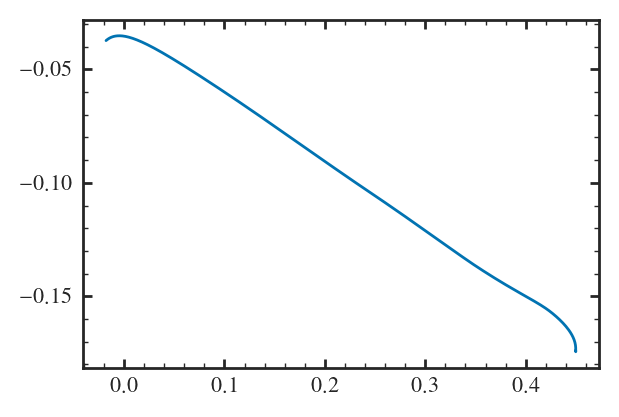

In [46]:
plot_model(model, soln.x)


/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/outputs/output.py:131: UserWarning: agb c yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


(-0.5, 0.2)

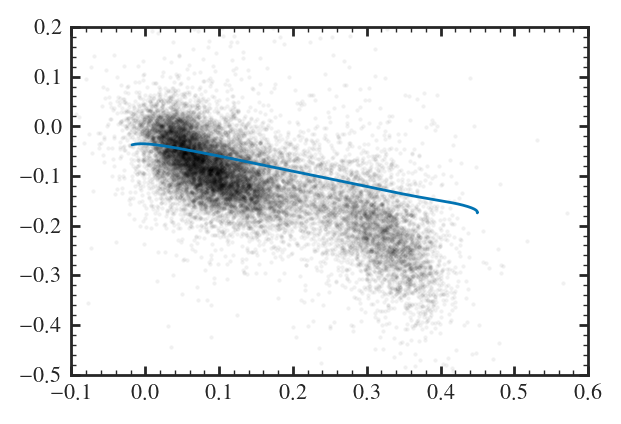

In [48]:
plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
plot_model(model, soln.x)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)

In [ ]:
Nwalkers = 2*Nparams
pos = initial* (1 + 0.01 * np.random.randn(Nwalkers, Nparams))

sampler = emcee.EnsembleSampler(
    Nwalkers, Nparams, model.log_likelihood, args=[obs]
)
sampler.run_mcmc(pos, 100, progress=True)

  9%|▉         | 9/100 [03:02<30:35, 20.17s/it]/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:322: UserWarning: Could not save object verbose with this VICE output.
  warnings.warn("""Could not save object %s with this VICE \


In [ ]:
import corner

In [ ]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

In [ ]:
fig = corner.corner(flat_samples, labels=[r"eta", "$tau_agb$", "$f_{\rm agb}$"]);

In [ ]:
sz_params()

In [ ]:
import arya

In [ ]:
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)

In [ ]:
for i in range(len(flat_samples)):
    plot_model(flat_samples[i, :], alpha=0.01, color="blue")

plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)